In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import pyNuHepMC as nhm

In [2]:
evs = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not evs:
    print("Error: failed to open input file")

In [3]:
%%capture
# the above line stops NEUT printouts
wf = pn.WeightCalcFactory()
t2krw = wf.make(evs, {"plugin_name":"T2KReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

Initializing with neut.t2kflux_numu_C_nofsi.card
 CRSPATH_ENV: /opt/neut/git_master/share/neut/crsdat
 Reading neut.t2kflux_numu_C_nofsi.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.t2kflux_numu_C_nofsi.card as a card file
Reading bank: NEUT from card file: neut.t2kflux_numu_C_nofsi.card
Reading bank: NEUT from card file: neut.t2kflux_numu_C_nofsi.card
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/git_master/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            1
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            1
 NECARD : NUCDEXITE =            0
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H 

In [4]:
pps.load_text("""
int isCC(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0xdeadbeef;
  }
  auto beam_pid = bpart->pid();
  auto cc_lep_pid = (beam_pid > 0)? (beam_pid - 1) : (beam_pid + 1);
  auto lep = ps::sel::OutPartHM(ev, cc_lep_pid);
  return bool(lep);
}

double enu_GeV(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0xdeadbeef;
  }
  return bpart->momentum().e() * 1E-3;
}

double q0_GeV(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0xdeadbeef;
  }
  auto beam_pid = bpart->pid();
  auto cc_lep_pid = (beam_pid > 0)? (beam_pid - 1) : (beam_pid + 1);
  auto lep = ps::sel::OutPartHM(ev, cc_lep_pid);
  if(!lep) {
      return 0xdeadbeef;
  }
  return ps::proj::parts::q0(bpart,lep)*1E-3;
}

double q3_GeV(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0xdeadbeef;
  }
  auto beam_pid = bpart->pid();
  auto cc_lep_pid = (beam_pid > 0)? (beam_pid - 1) : (beam_pid + 1);
  auto lep = ps::sel::OutPartHM(ev, cc_lep_pid);
  if(!lep) {
      return 0xdeadbeef;
  }
  return ps::proj::parts::q3(bpart,lep)*1E-3;
}

double Q2Lep_GeV(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0xdeadbeef;
  }
  auto beam_pid = bpart->pid();
  auto cc_lep_pid = (beam_pid > 0)? (beam_pid - 1) : (beam_pid + 1);
  auto lep = ps::sel::OutPartHM(ev, cc_lep_pid);
  if(!lep) {
      return 0xdeadbeef;
  }
  return ps::proj::parts::Q2(bpart,lep)*1E-6;
}
""")

True

In [5]:
import pprint

all_dials = []
for tgt in [ "C", ]:
    for nus in [ "nu", ]:
        for bi in range(3):
            all_dials.append("HFPW_toCRPAPWTwkDial_%s_%s_%s" % (tgt,nus,bi))
            all_dials.append("HFPW_toHFTwkDial_%s_%s_%s" % (tgt,nus,bi))

dial_tweaks = {}
for var in [1]:
    for di in all_dials:
        twk = {}
        for dj in all_dials:
            twk[dj] = var if di == dj else 0
        dial_tweaks["%s=%s" % (di,var)] = twk

dial_tweaks["CV"] = {"HFPW_toCRPAPWTwkDial_C_nu_0":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_1":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_2":0,
                     "HFPW_toHFTwkDial_C_nu_0":0,
                     "HFPW_toHFTwkDial_C_nu_1":0,
                     "HFPW_toHFTwkDial_C_nu_2":0}
# pprint.pp(dial_tweaks)
colnames = [ x for x in dial_tweaks.keys() ]
pprint.pp(colnames)

['HFPW_toCRPAPWTwkDial_C_nu_0=1',
 'HFPW_toHFTwkDial_C_nu_0=1',
 'HFPW_toCRPAPWTwkDial_C_nu_1=1',
 'HFPW_toHFTwkDial_C_nu_1=1',
 'HFPW_toCRPAPWTwkDial_C_nu_2=1',
 'HFPW_toHFTwkDial_C_nu_2=1',
 'CV']


In [14]:
def wghts(ev):
    resp = []
    for _,var in dial_tweaks.items():
        t2krw.set_parameters(var)
        resp.append(t2krw.calc_weight(ev))
    return resp

In [16]:
fg = pn.EventFrameGen(evs, 1000000)\
  .add_column("enu", pps.project.get("enu_GeV")) \
  .add_column("q0", pps.project.get("q0_GeV")) \
  .add_column("q3", pps.project.get("q3_GeV")) \
  .add_column("Q2Lep", pps.project.get("Q2Lep_GeV")) \
  .add_columns(colnames, wghts)

In [17]:
chunk = fg.first()

NIWGHadronTensor: reading hadron tensor table
table_file_name:  /root/software/NIWGReWeight/build/Linux/var/NIWG/hadronTensors/crpa_susav2/CRPA_1000060120_QE_Low.dat
Z:                6
A:                12
q0 bins:           170 between 0.0176657 and 0.0601657
q3 bins:           250 between 0.00899 and 2.00399
NIWGHadronTensor: reading hadron tensor table
table_file_name:  /root/software/NIWGReWeight/build/Linux/var/NIWG/hadronTensors/crpa_susav2/HF_1000060120_QE_Low.dat
Z:                6
A:                12
q0 bins:           170 between 0.0176657 and 0.0601657
q3 bins:           250 between 0.00899 and 2.00399
NIWGHadronTensor: reading hadron tensor table
table_file_name:  /root/software/NIWGReWeight/build/Linux/var/NIWG/hadronTensors/crpa_susav2/CRPA_1000060120_anu_QE_Low.dat
Z:                6
A:                12
q0 bins:           170 between 0.0176657 and 0.0601657
q3 bins:           250 between 0.00899 and 2.00399
NIWGHadronTensor: reading hadron tensor table
table_file_na

In [18]:
print(chunk)

 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | process.id |    enu |        q0 |        q3 |     Q2Lep | HFPW_toCRPA$ | HFPW_toHFTw$ | HFPW_toCRPA$ | HFPW_toHFTw$ | HFPW_toCRPA$ | HFPW_toHFTw$ | CV |
 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 |            0 |         1 |        251 |  0.473 | 3.736e+09 | 3.736e+09 | 3.736e+09 |            1 |            1 |            1 |            1 |            1 |            1 |  1 |
 |            1 |         1 |        550 |  3.259 | 3.736e+09 | 3.736e+09 | 3.736e+09 |            1 |            1 |            1 |            1 |            1 |            1 |  1 |
 |            2 |         1 |        400 | 0.6794 |    0.4122 |    0.4491 |   0.03183

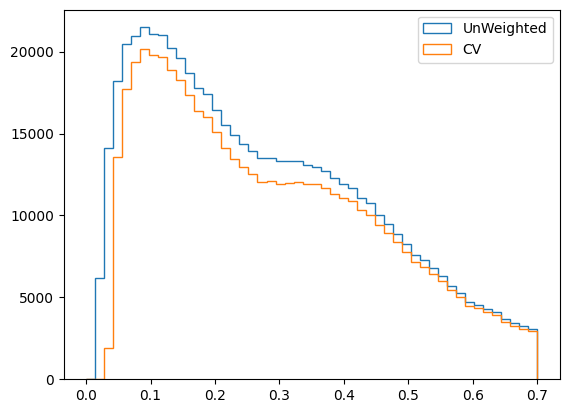

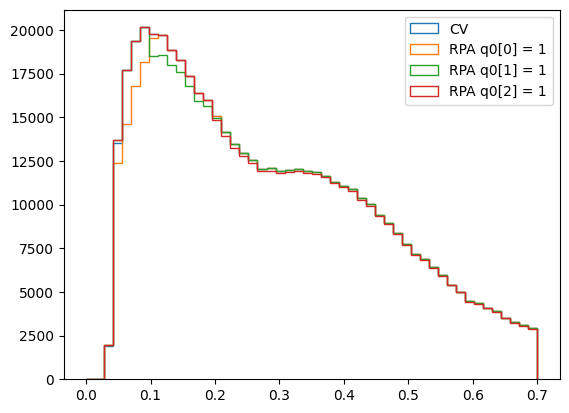

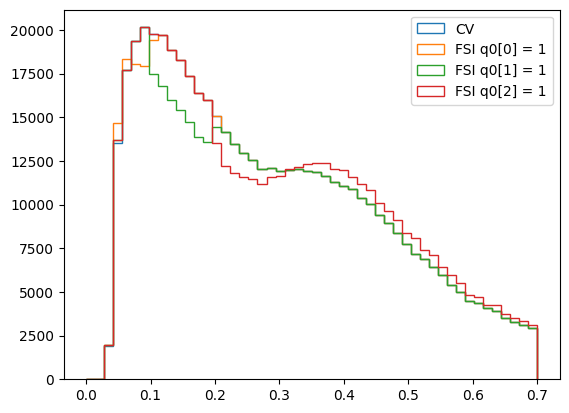

In [19]:
q0h = pn.HistFrame(pn.Binning.lin_space(0,0.7,50))
q0h.fill_weighted_columns_from_EventFrame(chunk,["q0"],
                                          [ "CV",
                                            "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"])

q0h.mpl().hist(histtype='step', label="UnWeighted")
q0h.mpl().hist(col="CV", histtype='step', label="CV")

pn.plt.legend()
pn.plt.show()

q0h.mpl().hist(col="CV", histtype='step', label="CV")
q0h.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_0=1", histtype='step', label="RPA q0[0] = 1")
q0h.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_1=1", histtype='step', label="RPA q0[1] = 1")
q0h.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_2=1", histtype='step', label="RPA q0[2] = 1")

pn.plt.legend()
pn.plt.show()

q0h.mpl().hist(col="CV", histtype='step', label="CV")
q0h.mpl().hist(col="HFPW_toHFTwkDial_C_nu_0=1", histtype='step', label="FSI q0[0] = 1")
q0h.mpl().hist(col="HFPW_toHFTwkDial_C_nu_1=1", histtype='step', label="FSI q0[1] = 1")
q0h.mpl().hist(col="HFPW_toHFTwkDial_C_nu_2=1", histtype='step', label="FSI q0[2] = 1")

pn.plt.legend()
pn.plt.show()

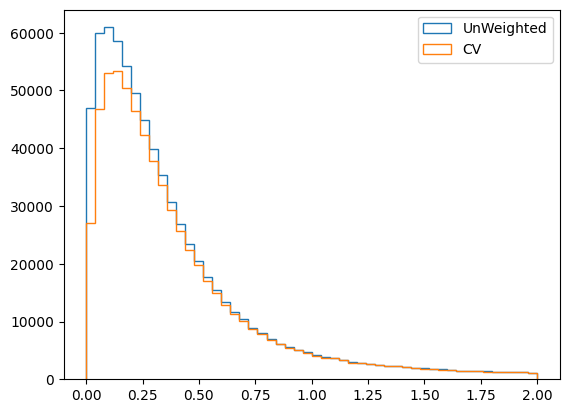

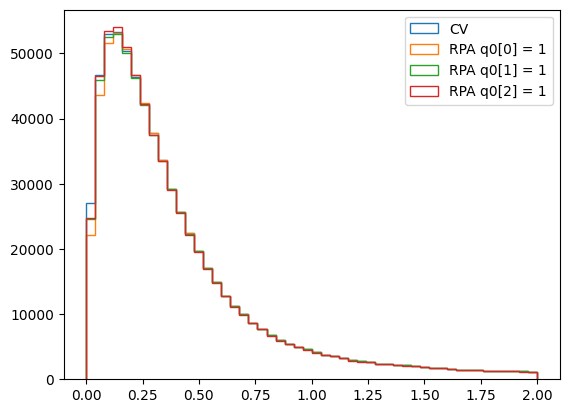

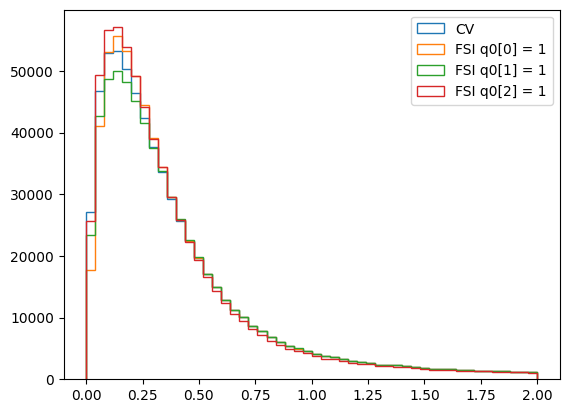

In [20]:
Q2Leph = pn.HistFrame(pn.Binning.lin_space(0,2,50))
Q2Leph.fill_weighted_columns_from_EventFrame(chunk,["Q2Lep"],
                                          [ "CV",
                                            "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"])

Q2Leph.mpl().hist(histtype='step', label="UnWeighted")
Q2Leph.mpl().hist(col="CV", histtype='step', label="CV")

pn.plt.legend()
pn.plt.show()

Q2Leph.mpl().hist(col="CV", histtype='step', label="CV")
Q2Leph.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_0=1", histtype='step', label="RPA q0[0] = 1")
Q2Leph.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_1=1", histtype='step', label="RPA q0[1] = 1")
Q2Leph.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_2=1", histtype='step', label="RPA q0[2] = 1")

pn.plt.legend()
pn.plt.show()

Q2Leph.mpl().hist(col="CV", histtype='step', label="CV")
Q2Leph.mpl().hist(col="HFPW_toHFTwkDial_C_nu_0=1", histtype='step', label="FSI q0[0] = 1")
Q2Leph.mpl().hist(col="HFPW_toHFTwkDial_C_nu_1=1", histtype='step', label="FSI q0[1] = 1")
Q2Leph.mpl().hist(col="HFPW_toHFTwkDial_C_nu_2=1", histtype='step', label="FSI q0[2] = 1")

pn.plt.legend()
pn.plt.show()